# Initializations

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import random
import re
import ast
import json
import pickle
import os

In [2]:
GLOBAL_SEED = 255

np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
torch.use_deterministic_algorithms(True)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


# preparing the environment

In [16]:
!nvcc --version  # Check CUDA version
print(torch.__version__)  # Check PyTorch version
print(torch.version.cuda)  # Check PyTorch's CUDA version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
2.5.1+cu124
12.4


In [17]:
!pip uninstall torch torchvision torchaudio -y


Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124


In [18]:
!pip install torch==2.5.1+cu124 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions 

In [19]:
!pip install fairseq2==v0.3.0rc1 --pre --extra-index-url  https://fair.pkg.atmeta.com/fairseq2/whl/rc/pt2.5.1/cu124 --upgrade

Looking in indexes: https://pypi.org/simple, https://fair.pkg.atmeta.com/fairseq2/whl/rc/pt2.5.1/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 382.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging

In [20]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu124
12.4


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# %cd /content/drive/MyDrive/University/Research/SemEval 2025: Task 7
%cd /content/drive/MyDrive/Research/SemEval 2025: Task 7

/content/drive/.shortcut-targets-by-id/1iZ2XHgIpDSkxPjihIgMQ_KPj766HC2So/Research/SemEval 2025: Task 7


  Data Properties:

      posts_df:
          posts['text'] is either a tuple of 3 or an empty string
          posts['ocr'] is a list of tuples of 3 which is the ocr for each picture

      fact_checks_df:
          fact_checks_df['title'] is either a tuple of 3 or an empty string
          fact_checks_df['claim'] is always a tuple of 3

      mapping_df:
          nothing especial

In [5]:
parse_col = lambda s: ast.literal_eval(s.replace('\n', '\\n')) if s else s


fact_checks_df = pd.read_csv('./data/cleaned data/fact_checks.csv').fillna('').set_index('fact_check_id')
# fact_checks_df = pd.read_csv('./data/cleaned data/fact_checks_test.csv').fillna('').set_index('fact_check_id')

for col in ['claim', 'title']:
    fact_checks_df[col] = fact_checks_df[col].apply(parse_col)


posts_df = pd.read_csv('./data/cleaned data/posts.csv').fillna('').set_index('post_id')
# posts_df = pd.read_csv('./data/cleaned data/posts_test.csv').fillna('').set_index('post_id')


mapping_df = pd.read_csv('./data/original data/pairs.csv')

with open('./data/original data/tasks.json', 'r') as file:
    tasks = json.load(file)

# with open('./data/test data/tasks.json', 'r') as file:
#     tasks = json.load(file)

# SONAR

## loading sonar model

In [6]:
!pip install sonar-space

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.2 MB/s eta 0:00:00
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40037 sha256=e3aff7925eac22b4175183f262387f4315719eedfbd5f2f1074b338703411a33
  Stored in directory: /root/.cache/pip/wheels/74/89/93/023fcdacaec4e5471e78b43992515e8500cc2505b307e2e6b7
Successfully built sox


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline

t2vec_model = TextToEmbeddingModelPipeline(encoder="text_sonar_basic_encoder", tokenizer="text_sonar_basic_encoder", device=device)

In [8]:
device

device(type='cuda')

In [9]:
language_mapping = {
    'ara': 'arb_Arab',
    'deu': 'deu_Latn',
    'tha': 'tha_Thai',
    'eng': 'eng_Latn',
    'fra': 'fra_Latn',
    'msa': 'ind_Latn',
    'por': 'por_Latn',
    'pol': 'pol_Latn',
    'spa': 'spa_Latn',
    'tur': 'tur_Latn',
    'hin': 'hin_Deva',
    'kor': 'kor_Hang',
    'sin': 'sin_Sinh',
    'tgl': 'tgl_Latn',
    'urd': 'urd_Arab',
    'zho': 'zho_Hans',
    'ben': 'ben_Beng',
    'hi-Latn': 'hi-Latn'
}

## building fact_checks embeddings

### preparing fact_checks *dataframe*

In [ ]:
file_path = './data/summaries/Qwen2.5-7B-Instruct/fact_check_summaries.csv'

if os.path.exists(file_path):
    # Load the existing dataframe
    FC_summaries = pd.read_csv(file_path).fillna('').set_index('fact_check_id')
    print("Dataframe loaded from file.")
else:
    # Create an empty dataframe with specific columns
    FC_summaries = pd.DataFrame(columns=['fact_check_id', 'summary']).set_index('fact_check_id')
    print("File not found. Created an empty dataframe.")

Dataframe loaded from file.


In [ ]:
fact_checks_df['content'] = fact_checks_df.apply(lambda r: r['claim'][0], axis=1)

In [ ]:
related_FC_summaries = FC_summaries.loc[FC_summaries.index.isin(fact_checks_df.index)]
related_FC_summaries

,summary
fact_check_id,
9136,Michel Temer exaggerated the time it took for ...
100280,"Pope Francis, along with other religious leade..."
9135,Michel Temer claimed his government approved a...
36946,"Senators debated the 2016 project 131/2015, wh..."
63469,The government's roadmap to ease COVID-19 rest...
...,...
327517,"Presidents of the European Parliament, Europea..."
329521,"In 10 years, Ukrainian schools will produce a ..."
316047,"Speculations about intercepted conversations, ..."


In [ ]:
# Inserting Summaries
fact_checks_df.loc[related_FC_summaries.index, 'content'] = related_FC_summaries['summary']
fact_checks_df.loc[related_FC_summaries.index, 'language'] = 'eng'

fact_checks_df.loc[fact_checks_df['language'].apply(lambda x: x == 'hi-Latn'), 'language'] = 'hin'

In [ ]:
# Group the DataFrame by claim language
grouped = fact_checks_df.groupby('language')

# Create a dictionary to store the grouped data
grouped_data = {}

# Iterate through each group and create a new DataFrame with only 'content' and index
for language, group in grouped:
  # Select only content and index columns
  new_df = group[['content']].copy()
  new_df['language'] = language  # Store the original index
  grouped_data[language] = new_df

# Example of accessing a group (replace 'en' with desired language):
# print(grouped_data['en'])


In [ ]:
tasks['monolingual'].keys()

dict_keys(['ara', 'deu', 'eng', 'fra', 'msa', 'pol', 'por', 'spa', 'tha', 'tur'])

In [ ]:
print(grouped_data.keys())

dict_keys(['ara', 'deu', 'eng', 'fra', 'hin', 'msa', 'pol', 'por', 'spa', 'tha', 'tur'])


In [ ]:
# grouped_data['hi-Latn']
#[20770, 65793, 93329, 105439, 130835, 153655]

In [ ]:
grouped_data['hin']

,content,language
fact_check_id,,
817,"""BH"" सीरीज़ की गाड़ी भारत के हर राज्य में चलाई...",hin
7465,"""इटली से अदिस अबाबा जाने वाली फ्लाइट"" में कोरो...",hin
7467,"""एबीपी न्यूज"" के एक सर्वे में ये बात सामने आई ...",hin
7468,"""एबीपी न्यूज"" ने एक सर्वे में बताया है कि 2022...",hin
7469,"""कहते है कर्म का नियम अटल है. कभी इसी अफगानिस्...",hin
...,...,...
372796,हरियाणा कांग्रेस स्टार प्रचारक ये भारत के टुकड़...,hin
372797,अब तो देश की नेशनल मीडिया ने भी माना की पश्चिम...,hin
372826,भारतीय सेना के समर्थन में शपथ लेते ये लोग पाकि...,hin


In [ ]:
for language, group in grouped:
    print(f"lang: {language}, len: {len(group)}")

lang: ara, len: 20208
lang: deu, len: 6050
lang: eng, len: 151504
lang: fra, len: 6102
lang: hin, len: 11209
lang: msa, len: 678
lang: pol, len: 8521
lang: por, len: 30932
lang: spa, len: 24204
lang: tha, len: 567
lang: tur, len: 12472


### building the embeddings

In [ ]:
folder_path = "./data/embeddings/train - fact_checks_embeddings/Sonar - Qwen2.5-7B-Instruct"
fact_checks_embeddings = {}
try:
  for lang in tqdm(grouped_data.keys(), desc="Processing Batches"):
    src_lang = language_mapping[lang]
    sentences = grouped_data[lang]['content'].to_list()
    indexes = grouped_data[lang].index.to_list()
    output = t2vec_model.predict(sentences, source_lang=src_lang)
    embed_sentence = torch.nn.functional.normalize(output, dim=-1).cpu().numpy()
    lang_embdings = dict(zip(indexes, embed_sentence))
    fact_checks_embeddings.update(lang_embdings)
    # pd.DataFrame({'embedding': lang_embdings.values()}, index=lang_embdings.keys()).to_pickle(f'{folder_path}/{lang}_fact_checks_embeddings.pkl')
    pd.DataFrame({'embedding': lang_embdings.values()}, index=lang_embdings.keys()).to_pickle(f'{folder_path}/test_{lang}_fact_checks_embeddings.pkl')
    print(f'{lang} Compeleted!')
except Exception as e:
    print("The error is: ", e)
finally:
#   pd.DataFrame({'embedding': fact_checks_embeddings.values()}, index=fact_checks_embeddings.keys()).to_pickle(f'{folder_path}/fact_checks_embeddings.pkl')
  pd.DataFrame({'embedding': fact_checks_embeddings.values()}, index=fact_checks_embeddings.keys()).to_pickle(f'{folder_path}/test_fact_checks_embeddings.pkl')

Processing Batches:   9%|▉         | 1/11 [06:03<1:00:38, 363.88s/it]

ara Compeleted!


Processing Batches:  18%|█▊        | 2/11 [07:49<31:45, 211.73s/it]  

deu Compeleted!


/usr/local/lib/python3.11/dist-packages/sonar/inference_pipelines/text.py:204: UserWarning: For 1 input tensors for SONAR text encoder, the length was truncated to 514 elements.
  warnings.warn(
Processing Batches:  27%|██▋       | 3/11 [46:54<2:38:08, 1186.00s/it]

eng Compeleted!


Processing Batches:  36%|███▋      | 4/11 [48:29<1:28:05, 755.13s/it] 

fra Compeleted!


Processing Batches:  45%|████▌     | 5/11 [51:19<54:25, 544.21s/it]  

hin Compeleted!


Processing Batches:  55%|█████▍    | 6/11 [51:27<30:09, 361.94s/it]

msa Compeleted!


Processing Batches:  64%|██████▎   | 7/11 [54:43<20:30, 307.64s/it]

pol Compeleted!


Processing Batches:  73%|███████▎  | 8/11 [1:03:00<18:23, 367.93s/it]

por Compeleted!


Processing Batches:  82%|████████▏ | 9/11 [1:08:57<12:09, 364.66s/it]

spa Compeleted!


Processing Batches:  91%|█████████ | 10/11 [1:09:06<04:14, 254.63s/it]

tha Compeleted!


Processing Batches: 100%|██████████| 11/11 [1:12:33<00:00, 395.74s/it]

tur Compeleted!


In [ ]:
with open(f"{folder_path}/test_fact_checks_embeddings.pkl", "rb") as file:
    my_object = pickle.load(file)

my_object

,embedding
18,"[0.04028098, -0.0069865207, 0.001434556, 0.009..."
161,"[0.030278668, 0.012276127, -0.010818236, 0.002..."
4844,"[0.024657056, 0.03652718, -0.05393669, 0.01411..."
7348,"[0.035372213, -0.06317737, 0.0035133606, 0.006..."
7349,"[0.04321432, -0.059000116, 0.05798509, 0.01438..."
...,...
372756,"[-0.020781709, -0.006882164, -0.02510284, 0.01..."
372780,"[-0.017979303, 0.039209332, -0.03269766, 0.010..."
372801,"[0.06419877, 0.03237529, 0.016609844, 0.038856..."
372851,"[0.05180096, -0.039439783, -0.016875304, 0.024..."


## building posts embeddings

### preparing posts dataframe

In [10]:
file_path = './data/summaries/Qwen2.5-7B-Instruct/posts_summaries.csv'

if os.path.exists(file_path):
    # Load the existing dataframe
    posts_summaries = pd.read_csv(file_path).fillna('').set_index('post_id')
    print("Dataframe loaded from file.")
else:
    # Create an empty dataframe with specific columns
    posts_summaries = pd.DataFrame(columns=['post_id', 'summary']).set_index('post_id')
    print("File not found. Created an empty dataframe.")

Dataframe loaded from file.


In [11]:
related_post_summaries = posts_summaries.loc[posts_summaries.index.isin(posts_df.index)]
related_post_summaries

,summary
post_id,
21013,Prolonged use of masks can lead to hypercapnia...
5925,Joseph C De Gregorio and Tina M Brown pledge n...
15231,"The Mexican government plans to spend 5,792,11..."
26071,"On May 30, 2021, in Yongin Suji, videos claimi..."
27199,Weakened blood vessels in the head can rupture...
...,...
9720,"While humanity is in quarantine, Planet Earth ..."
3951,Painful scenes of oppression and suffering on ...
24262,The court has asked to seal the Shivling found...


In [12]:
posts_df.loc[related_post_summaries.index, 'eng_content'] = related_post_summaries['summary']
posts_df.loc[related_post_summaries.index, 'language'] = 'eng'

## Creating Outputs

In [ ]:
len(tasks['crosslingual']['posts_test'])

4000

In [ ]:
for lang in tasks['monolingual'].keys():
    print(f"lang: {lang}, posts: { len(tasks['monolingual'][lang]['posts_test']) }, fc: { len(tasks['monolingual'][lang]['fact_checks']) }")

lang: ara, posts: 500, fc: 21153
lang: deu, posts: 500, fc: 7485
lang: eng, posts: 500, fc: 145287
lang: fra, posts: 500, fc: 6316
lang: msa, posts: 93, fc: 686
lang: pol, posts: 500, fc: 8796
lang: por, posts: 500, fc: 32598
lang: spa, posts: 500, fc: 25440
lang: tha, posts: 183, fc: 583
lang: tur, posts: 500, fc: 12536


In [13]:
with open("./data/embeddings/train - fact_checks_embeddings/Sonar - Qwen2.5-7B-Instruct/fact_checks_embeddings.pkl", "rb") as file:
    fact_checks_embeddings = pickle.load(file)

fact_checks_embeddings


,embedding
18,"[0.04028098, -0.0069865207, 0.001434556, 0.009..."
161,"[0.030278668, 0.012276127, -0.010818236, 0.002..."
4844,"[0.024657056, 0.03652718, -0.05393669, 0.01411..."
7348,"[0.035372213, -0.06317737, 0.0035133606, 0.006..."
7349,"[0.04321432, -0.059000116, 0.05798509, 0.01438..."
...,...
193605,"[-0.032449882, -0.018417096, -0.050098147, -0...."
193606,"[0.079181455, -0.01834051, -0.033613656, -0.02..."
193607,"[-0.0024266732, 0.052487995, 0.013760233, -0.0..."
193608,"[0.008355364, -0.0031122945, -0.04364193, -0.0..."


In [14]:
def get_posts_embeddings(post_df, batch_size=16):
    sample_embeddings = []
    sample_post_ids = []

    for i in range(0, len(post_df), batch_size):
        batch_df = post_df.iloc[i:i + batch_size]
        contents = batch_df['eng_content'].tolist()

        # Batch process embeddings
        outputs = t2vec_model.predict(contents, source_lang='eng_Latn')
        embeddings = torch.nn.functional.normalize(outputs, dim=-1).cpu().numpy()

        sample_embeddings.extend(embeddings)
        sample_post_ids.extend(batch_df.index.tolist())

    return sample_post_ids, sample_embeddings

# def find_nearest_fact_checks(matrix, K):
#     return np.argpartition(matrix, -K, axis=1)[:, -K:]

def find_relevant_fact_checks(posts_embeddings, fact_checks_embeddings, K = 10, alpha = 3):
    cos_sim = cosine_similarity(posts_embeddings, fact_checks_embeddings['embedding'].to_list())
    # cos_sim = np.array(posts_embeddings).dot(np.array(fact_checks_embeddings['embedding'].to_list()).T)

    nearest = np.argpartition(cos_sim, -K, axis=1)[:, -K:]
    similars = np.argpartition(cos_sim, -(alpha * K), axis=1)[:, -(alpha * K):]

    return nearest, similars

def get_fact_checks(post_id):
    FCs = mapping_df[mapping_df['post_id'] == post_id]['fact_check_id'].to_list()
    return fact_checks_df.loc[FCs].index.to_list()

def common_element(list1, list2):
    return any(item in list2 for item in list1)

def get_accuracy(posts_ids, top_indices_ids, show_logs = False):
    mismatched_posts = []
    corrects = 0
    for i, p in enumerate(posts_ids):
      FCs = get_fact_checks(p)
      result = common_element(FCs, top_indices_ids[i])

      if show_logs:
        print("=================================================================")
        print(f'fact_checks for post {p}')
        print(f"content: {posts_df.loc[p]['content']}")
        print(FCs)
        for x in FCs:
          print(f"title: {fact_checks_df.loc[x]['title']}")
          print(f"claim: {fact_checks_df.loc[x]['claim'][1]}")
        print(result)
      corrects += result == True
      if not result:
        mismatched_posts.append(p)
    return corrects, mismatched_posts

def build_outputs(posts, fact_checks_embeddings, batch_size = 16):
    similarities = []
    corrects = 0
    mismatched_posts = []
    top_indices = []

    for i in tqdm(range(0, len(posts), batch_size), desc="Processing Batches"):
        batch_df = posts.iloc[i:i + batch_size]
        batch_ids, batch_embeddings = get_posts_embeddings(batch_df, batch_size)
        batch_top_indices, batch_similarities = find_relevant_fact_checks(batch_embeddings, fact_checks_embeddings)

        batch_top_indices_ids = [fact_checks_embeddings.iloc[batch_top_indices[i]].index for i in range(len(batch_ids))]

        top_indices.extend(batch_top_indices_ids)
        # similarities.extend(batch_similarities)
        batch_corrects, batch_mismatched_posts = get_accuracy(batch_ids, batch_top_indices_ids)
        corrects += batch_corrects
        # mismatched_posts.extend(batch_mismatched_posts)

    accuracy = corrects / len(posts) * 100
    return accuracy, mismatched_posts, top_indices, similarities

In [ ]:
for lang in tasks['monolingual'].keys():
    posts = posts_df.loc[tasks['monolingual'][lang]['posts_test']]
    fc_embeddings = fact_checks_embeddings.loc[tasks['monolingual'][lang]['fact_checks']]
    print(f'lang: {lang}, posts: {len(posts)}, fc: {len(fc_embeddings)}')

In [ ]:
test_posts_ids = []
test_posts_ids.extend(tasks['crosslingual']['posts_test'])
for lang in tasks['monolingual'].keys():
    test_posts_ids.extend(tasks['monolingual'][lang]['posts_test'])

In [ ]:
len(test_posts_ids)

8276

In [ ]:
posts_df.loc[[ind for ind in test_posts_ids if ind in posts_summaries.index.to_list()]]

,ocr,text,content,eng_content,language
post_id,,,,,
28101,,"A student in Bremen, Germany found an online s...","A student in Bremen, Germany found an online s...","A student in Bremen, Germany reported an onlin...",eng
28136,,रामराज्य उत्तर प्रदेश में..... जिले बदायूं में...,रामराज्य उत्तर प्रदेश में..... जिले बदायूं में...,"A petrol filling employee in Badaun, Uttar Pra...",eng
28142,WHEN A TYRANT TELLS YOU TO BE SAFE AT HOME YET...,Here is another hypocritical idiot like Nancy ...,WHEN A TYRANT TELLS YOU TO BE SAFE AT HOME YET...,Kentucky Governor Andy Beshear attended the Ke...,eng
28147,,प्रयागराज में शुक्रवार के दिन अटाले पर जहां दं...,प्रयागराज में शुक्रवार के दिन अटाले पर जहां दं...,Riots occurred in Prayagraj on Friday; inform ...,eng
28149,Mark Zuckerberg 6 hrs - Facebook for Android -...,As whatsap and facebook is about to go on one ...,Mark Zuckerberg 6 hrs - Facebook for Android -...,"Facebook, Instagram, WhatsApp, and Messenger w...",eng
...,...,...,...,...,...
78895,,Bu görüntü şimdi geldi Istanbul ve THY gibi..?...,Bu görüntü şimdi geldi Istanbul ve THY gibi..?...,The image shows Istanbul and THY (Turkish Airl...,eng
78909,,"Dilan Polat, Silivri Cezaevi'nde bulunan acil ...","Dilan Polat, Silivri Cezaevi'nde bulunan acil ...",Dilan Polat is examined in the emergency room ...,eng
79103,,"Pakistan o kadar azgın, cinsel açıdan hüsrana ...","Pakistan o kadar azgın, cinsel açıdan hüsrana ...",Pakistan has imposed padlocks on daughters' gr...,eng


In [ ]:
with open('./data/test data/monolingual_predictions.json', 'r') as file:
    monolingual_predictions = json.load(file)

with open('./data/test data/crosslingual_predictions.json', 'r') as file:
    crosslingual_predictions = json.load(file)

### monolingual posts

In [61]:
mismatched_posts = []

In [15]:
tasks['monolingual']['eng'].keys()

dict_keys(['fact_checks', 'posts_train', 'posts_dev'])

In [18]:
posts_summaries.index.isin(tasks['monolingual']['eng']['posts_train'])

array([False, False, False, ..., False, False,  True])

In [19]:
tasks['monolingual']['eng']['posts_train'].isin(posts_summaries.index)

AttributeError: 'list' object has no attribute 'isin'

In [21]:
posts_df.[list(posts_summaries.index.intersection(tasks['monolingual']['eng']['posts_train']))]

,ocr,text,content,eng_content,language
post_id,,,,,
5848,"LLLLL HEAR 224 ""ALLAH WWW.LA a ASHIUNA SS",And then Life happened I love you Mama,"LLLLL HEAR 224 ""ALLAH WWW.LA a ASHIUNA SSAnd t...",The text does not contain enough factual infor...,eng
15938,,Osun Decides Daivdo is just shutting the stree...,Osun Decides Daivdo is just shutting the stree...,"Adeleke of PDP is winning in Osun, where Daivd...",eng
19633,,"This man here, “General” Kipngetich was hired ...","This man here, “General” Kipngetich was hired ...","General Kipngetich, hired by UDA, heckled and ...",eng
6509,It's Apple Research NGA T OFFICIAL LAUNCH COVI...,BREAKING NEWS. MADAGASCAR HAS FOUND A CURE FOR...,It's Apple Research NGA T OFFICIAL LAUNCH COVI...,Madagascar has discovered a herb called Covid-...,eng
22095,the SUDDEN ADULT DEATH SYNDROME KILLED HIM JEF...,the new thing SADS,the SUDDEN ADULT DEATH SYNDROME KILLED HIM JEF...,Sudden Adult Death Syndrome killed him.,eng
...,...,...,...,...,...
7194,"The Ukraine Ukraine. The exact same explosion,...",CNN will lie when the truth is better:,"The Ukraine Ukraine. The exact same explosion,...","Overnight explosion in Ukraine, 7 years after ...",eng
16376,ATS GOODBYE DUTERTE! R LANE WELCOME SOON INDAY...,Past and Future President,ATS GOODBYE DUTERTE! R LANE WELCOME SOON INDAY...,ATS goodbye Duterte; R Lane welcome Sara Duter...,eng
18572,EPSTEIN'S FORMER PILOT NAMES HIGH PROFILE PASS...,So this is about the Jeffery Epstein’s pedophi...,EPSTEIN'S FORMER PILOT NAMES HIGH PROFILE PASS...,Jeffrey Epstein's former pilot testified durin...,eng


In [63]:
# for lang in ['eng']:
for lang in tasks['monolingual'].keys():
    print(f'{lang} started...')
    # posts = posts_df.loc[[ind for ind in tasks['monolingual'][lang]['posts_train'] if ind in posts_summaries.index.to_list()]]
    # posts = posts_df.loc[tasks['monolingual'][lang]['posts_test']]
    posts = posts_df.loc[posts_summaries.index.isin(tasks['monolingual'][lang]['posts_train'])]
    fc_embeddings = fact_checks_embeddings.loc[tasks['monolingual'][lang]['fact_checks']]
    print(f'lang: {lang}, posts: {len(posts)}, fc: {len(fc_embeddings)}')
    accuracy, mismatches, top_indices, similarities = build_outputs(posts, fact_checks_embeddings, batch_size=32)

    # monolingual_predictions.update(dict(zip([str(ind) for ind in posts.index.to_list()], [x.to_list() for x in top_indices])))
    # np.save(f'./results/dev_sonar_monolingual_{lang}.npy', similarities)
    # with open(f'./results/Sonar - Qwen2.5-7B-Instruct/test_sonar_monolingual_{lang}.json', 'w') as json_file:
    #     json.dump(dict(zip([str(ind) for ind in posts.index.to_list()], [x.tolist() for x in similarities])), json_file, indent=4)

    for p in mismatches:
        mismatched_posts.append({'post_id': p, 'content': posts_df.loc[p]['content'], 'language': lang})

    print(f'language: {lang} completed with {accuracy}% accuracy!')

ara started...


KeyError: 'posts_train'

In [ ]:
file_path = './results/Submissions/Qwen2.5-7B & Sonar/Test'

with open(f'{file_path}/monolingual_predictions.json', 'w') as json_file:
    json.dump(monolingual_predictions, json_file, indent=4)

### crosslingual outputs

In [ ]:
# Crosslingual

# posts = posts_df.loc[tasks['crosslingual']['posts_train']]
# posts = posts_df.loc[[ind for ind in tasks['crosslingual']['posts_train'] if ind in posts_summaries.index.to_list()]]
posts = posts_df.loc[tasks['crosslingual']['posts_test']]
fc_embeddings = fact_checks_embeddings.loc[tasks['crosslingual']['fact_checks']]
print(f'posts: {len(posts)}, fc: {len(fc_embeddings)}')
accuracy, mismatches, top_indices, similarities = build_outputs(posts, fact_checks_embeddings, batch_size = 16)

crosslingual_predictions.update(dict(zip([str(ind) for ind in posts.index.to_list()], [x.to_list() for x in top_indices])))
# np.save(f'./results/dev_sonar_crosslingual.npy', similarities)
with open(f'./results/Sonar - Qwen2.5-7B-Instruct/test_sonar_crosslingual.json', 'w') as json_file:
    json.dump(dict(zip([str(ind) for ind in posts.index.to_list()], [x.tolist() for x in similarities])), json_file, indent=4)

for p in mismatches:
    mismatched_posts.append({'post_id': p, 'content': posts_df.loc[p], 'language': 'crosslingual'})

print(f'Crosslingual completed with {accuracy}% accuracy!')

posts: 4000, fc: 272447


Processing Batches: 100%|██████████| 250/250 [10:11<00:00,  2.45s/it]

Crosslingual completed with 0.0% accuracy!


In [ ]:
len(crosslingual_predictions)

4000

In [ ]:
file_path = './results/Submissions/Qwen2.5-7B & Sonar/Test'

with open(f'{file_path}/crosslingual_predictions.json', 'w') as json_file:
    json.dump(crosslingual_predictions, json_file, indent=4)

### Mismatched posts

In [ ]:
mismatched_posts_df = pd.DataFrame(mismatched_posts)
mismatched_posts_df = mismatched_posts_df.set_index('post_id')

In [ ]:
mismatched_posts_df

,content,language
post_id,,
158,11:36 V | Lea Nehuda O il y a 20h Elle a trop ...,fra
565,Berlin 29 août : Les policiers allemands ont r...,fra
602,CAR STILL ONE La premiere ministre du Queensla...,fra
714,"DANGEREUX S'il vous plait, souvenez-vous qu'il...",fra
734,"DIRECT: , Ministre de la Santé << Si votre fam...",fra
...,...,...
27750,"ocr Macron's ""mujer"" operada de la ...",crosslingual
27794,ocr ...,crosslingual
27995,ocr ...,crosslingual


### Manual testing

In [ ]:
posts_ids, posts_embeddings = get_posts_embeddings(posts_df.loc[[112, 976]]) # 1:04

In [13]:
file_path = './data/summaries/Qwen2.5-7B-Instruct/posts_summaries.csv'

if os.path.exists(file_path):
    # Load the existing dataframe
    posts_summaries = pd.read_csv(file_path).fillna('').set_index('post_id')
    print("Dataframe loaded from file.")
else:
    # Create an empty dataframe with specific columns
    posts_summaries = pd.DataFrame(columns=['post_id', 'summary']).set_index('post_id')
    print("File not found. Created an empty dataframe.")

Dataframe loaded from file.


In [42]:
posts_ids = [7194]
sentences = posts_summaries.loc[posts_ids]['summary'].to_list()
sentences

['Overnight explosion in Ukraine, 7 years after a similar incident, at 5:06 AM ET.']

In [43]:
output = t2vec_model.predict(sentences, source_lang="eng_Latn")
embed_sentence = torch.nn.functional.normalize(output, dim=-1).cpu().numpy()

In [44]:
embed_sentence

array([[-0.00674939, -0.01760257, -0.00262101, ...,  0.01012364,
         0.0031327 , -0.00521671]], dtype=float32)

In [45]:
posts_df.loc[posts_ids]

,ocr,text,content,eng_content,language
post_id,,,,,
7194,"The Ukraine Ukraine. The exact same explosion,...",CNN will lie when the truth is better:,"The Ukraine Ukraine. The exact same explosion,...","The Ukraine Ukraine. The exact same explosion,...",eng


In [46]:
top_indices, sims = find_relevant_fact_checks(embed_sentence, fact_checks_embeddings)

In [47]:
fact_checks_embeddings.iloc[top_indices[0]].index

Index([144249, 59309, 144716, 34184, 140480, 112666, 55424, 19359, 34115,
       79767],
      dtype='int64')

In [48]:
fact_checks_embeddings.iloc[top_indices[0]].index.to_list()

[144249, 59309, 144716, 34184, 140480, 112666, 55424, 19359, 34115, 79767]

In [49]:
top_indices_ids = [fact_checks_embeddings.iloc[top_indices[i]].index for i in range(len(posts_ids))]

In [56]:
posts_summaries.loc[7194].summary

'Overnight explosion in Ukraine, 7 years after a similar incident, at 5:06 AM ET.'

In [50]:
accuracy, mismatched_posts = get_accuracy(posts_ids, top_indices_ids, True)
print(f'accuracy: {accuracy}%')

fact_checks for post 7194
content: The Ukraine Ukraine. The exact same explosion, 7 years apart... NEW OVERNIGHT LIVE FIREY BUT MOSTLY PEACEFUL EXPLOSION IN THE UKRAINE CAN 5:06 AM ET BOSTON 87 NEW YORK C90° PHILADELPHIA 91¹ TODAY DR WHEREVER YOU GET YOUR FAVORITE PODCASTS ON.com PROTESTS EARLY START Esplosione Ucraina 2015 1 ore faCNN will lie when the truth is better:
[34164]
title: ('Fake CNN screenshot misleads on war in Ukraine', 'Fake CNN screenshot misleads on war in Ukraine', [('eng', 1.0)])
claim: CNN misrepresented image of 2015 explosion as being from 2022 Ukraine war
False
accuracy: 0%


In [51]:
fc_embd = fact_checks_embeddings.loc[fact_checks_embeddings.iloc[top_indices[0]].index.to_list()]['embedding'].to_list()

In [52]:
tmp = np.array(embed_sentence).dot(np.array(fc_embd).T)
tmp

array([[0.33878946, 0.3402635 , 0.3596004 , 0.37752262, 0.35426718,
        0.3406136 , 0.36757898, 0.34246272, 0.36103123, 0.39485562]],
      dtype=float32)

In [54]:
np.array(embed_sentence).dot(np.array(fact_checks_embeddings.loc[34164]['embedding'].tolist()).T)

array([0.22320096])

In [40]:
np.argpartition(tmp, -3, axis=1)[:, -3:]

array([[6, 5, 9]])

In [57]:
post_id = 7194
for x in fact_checks_df.loc[fact_checks_embeddings.iloc[top_indices[posts_ids.index(post_id)]].index]['claim'].to_list():
  print(x[1])
  print("-------------------------------------------------------")

Video shows explosion in Ukraine
-------------------------------------------------------
Photo shows explosion in Ukraine after Russian attack
-------------------------------------------------------
Video shows recent explosion in Ukraine.
-------------------------------------------------------
CNN publishes the exact same explosion in the Ukraine seven years apart.
-------------------------------------------------------
Video Of a recent explosion in Ukraine
-------------------------------------------------------
Recent photo of Ukraine after the Russian attack
-------------------------------------------------------
Explosion in Ukraine led by Russia
-------------------------------------------------------
A video shows a recent explosion in Ukraine
-------------------------------------------------------
CNN broadcasts the same explosion 7 years apart in the Russian invasion of Ukraine
-------------------------------------------------------
CNN broadcast the same explosion in Ukraine 7

In [ ]:
output = t2vec_model.predict(posts_df.loc[mismatched_posts]['content'].to_list(), source_lang='eng_Latn')
embed_sentence = torch.nn.functional.normalize(output, dim=-1).cpu().numpy()

In [ ]:
embed_sentence

array([[ 0.07701571,  0.01663807, -0.05843907, ..., -0.0141303 ,
         0.01106005,  0.01486295]], dtype=float32)

In [36]:
len(fc_embd)

10

In [ ]:
# shorted examples from FLORES dataset
# english_sentences = [
#     "Public school lockdown in Smithers BC due to RCMP arrest of Wet'suwet'en residents' children; children nearly taken but released without charges. State violence used against Canadians. Action needed to protect democratic freedoms.",
#     "Pfizer patents method for tracking vaccinated individuals via internet-connected devices using 2.4 GHz microwaves.",
# ]

english_sentences = posts_df.loc[posts_ids]['content'].to_list()

french_sentences = [
    "False report of BC school lockdown amid RCMP response to pipeline blockade: School in Smithers was put on lockdown after RCMP attempted to aprehend anti-pipeline protesters' children",
    "Social media users falsely link Pfizer to Covid-19 monitoring invention: Patents for Covid-19 vaccine tracking technology submitted by Pfizer",
]

In [ ]:
output_eng = t2vec_model.predict(english_sentences, source_lang="eng_Latn")
embed_english_sentence = torch.nn.functional.normalize(output_eng, dim=-1).cpu().numpy()

In [ ]:
output_fr = t2vec_model.predict(french_sentences, source_lang="eng_Latn")
embed_french_sentence = torch.nn.functional.normalize(output_fr, dim=-1).cpu().numpy()

In [ ]:
embed_french_sentence

array([[ 0.00684454,  0.03084884,  0.00309211, ...,  0.00649992,
        -0.02468841,  0.01219413],
       [ 0.05183253,  0.02667436, -0.0074333 , ...,  0.01128035,
         0.01195226,  0.01264431]], dtype=float32)

[[0.3684899  0.10488845]
 [0.1253013  0.31000242]]


<Axes: >

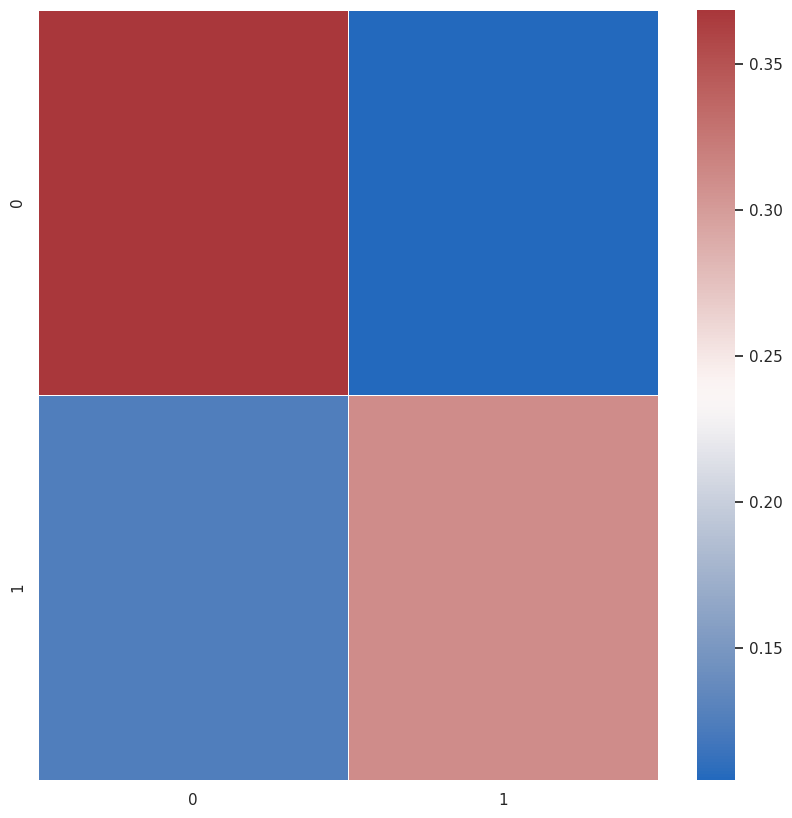

In [ ]:
import pandas as pd
import seaborn as sns

cos_sim = np.array(embed_english_sentence).dot(np.array(embed_french_sentence).T)
print(cos_sim)
sim_df = pd.DataFrame(cos_sim)
sns.set(font_scale=0.8)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(sim_df, cmap="vlag", linewidths=0.5)

In [25]:
post_id = 19633
for x in fact_checks_df.loc[fact_checks_embeddings.iloc[top_indices[posts_ids.index(post_id)]].index]['claim'].to_list():
  print(x[1])
  print("-------------------------------------------------------")

GOP congressional candidate DeAnna Lorraine tweeted praise for accused Kenosha shooter Kyle Rittenhouse.
-------------------------------------------------------
President Akufo-Addo took Former President Rawlings to court to challenge his Ghanaian nationality
-------------------------------------------------------
EFCC arrests Obasanjo and Goodluck Jonathan
-------------------------------------------------------
"THE DETENTION OF FAUCHI. On Saturday, April 9, US Special Forces arrested Deep State Chief and Plenary Architect Dr. Anthony Fauci on charges of treason, mass medical abuse, rebel conspiracy, and criminal murder. (. ..)"
-------------------------------------------------------
Kenya's presidential candidate Raila Odinga vows to end Christianity
-------------------------------------------------------
Violence in Bengaluru, police using tear gas
-------------------------------------------------------
Statue of Kenya's Raila Odinga erected in South Africa
-------------------------

In [ ]:
for x in fact_checks_df.loc[fact_checks_embeddings.iloc[top_indices[0]].index]['title'].to_list():
  print(x)
  print("-------------------------------------------------------")

('Chloroquine Does NOT Cure Coronavirus!', 'Chloroquine Does NOT Cure Coronavirus!', [('eng', 1.0)])
-------------------------------------------------------
('Did Fauci Compare Research About COVID-19 to That of Chickenpox?', 'Did Fauci Compare Research About COVID-19 to That of Chickenpox?', [('eng', 1.0)])
-------------------------------------------------------
('Es falso que el coronavirus SARS-CoV-2 tenga una patente', 'It is false that the SARS-CoV-2 coronavirus has a patent', [('spa', 1.0)])
-------------------------------------------------------
('سارس-كوف-2 فيروس لم يتم تصنيعه ولا تتسبّب لقاحاته في تغيير الشيفرة الوراثية', 'SARS-CoV-2 is not a virus that has not been synthesized and its vaccines do not change the genetic code', [('ara', 1.0)])
-------------------------------------------------------
('COVID-19 vaccine candidates are generally safe and effective at preventing disease; ongoing studies investigate whether the vaccine can also reduce transmission', 'COVID-19 vaccine

In [ ]:
###################### I should use summarizations ||| use title instead of claim ||| probably don't use ocr when text is available => maybe not a good idea as text is sometimes not comprehensive

# Error Analysis

In [ ]:
# some pairs of claims and fact-checks cannot be determined just by knowing the paris context. Addional information is required!
# e.g. post: 7368 and FC: 84774 ||

In [ ]:
# for some posts, the attention is on other parts rather than important parts like Names, cities, countries. Should be more attention on these parts

In [ ]:
mismatched_posts = pd.read_csv('./data/cleaned data/mismatched_data.csv').set_index('post_id')

In [ ]:
mismatched_posts

,content,language
post_id,,
610,IHU publishes groundbreaking hydroxychloroquin...,fra
631,Endoscopic nasal insertion endangers blood-bra...,fra
976,Chloroquine shows potent antiviral effects aga...,fra
1003,"Belgian schools reopen with no mask mandates, ...",fra
1004,Belgian schools can resume with no masks or ot...,fra
...,...,...
27907,ocr HIVYOBA A ove Ⓒ...,crosslingual
27954,ocr News USA Military Arrests Bill ...,crosslingual
27986,ocr ...,crosslingual


In [ ]:
posts_df.loc[3216].content

"I REPUBLIQUE DU CAMEROUN Paix-Travail-Patrie ******* MINISTERE DE LA SANTE PUBLIQUE ********* SECRETARIAT GENERAL ********** DELEGATION REGIONALE DE LA SANTE PUBLIQUE DU CENTRE ********* SGI- COVID 19 ********* 2. AZITHROMYCINE 250mg: 06 CP 2 cp en prise unique le 1 jour, puis, 1 cp/jr du 2 au 5e jour. DANS LA MESURE DU POSSIBLE, AJOUTER : 3. VITAMINE C 1000mg: 10cp lep dans un demi vers d'eau le matin REPUBLIC OF CAMEROON Peace-Work-Fatherland ******* 4. ZINC 20 mg: 05 cp MINISTRY OF PUBLIC HEALTH ********* 1. PLAQUENIL (HYDROXYCHLOROQUINE) 200mg CP: 10CP I cp matin 1 ep soir, pendant 05 jours et chaque prise après un repas lep dans un demi vers d'eau le matin 5. Boire beaucoup de boissons chaudes GENERAL SECRETARIAT ********** PUBLIC HEALTH DELEGATION OF THE CENTER REGION PLAN DE MISE SOUS TRAITEMENT POUR UN PATIENT ADULTE DEPISTE COVID 19++ ********* COVID 19-IMS *********Vs  LE PROTOCOLE. COVID-19  Le virus à muté!!! Il peut se manifester autrement, ne vous fiez pas aux anciens sy

In [ ]:
def sort_df(df, column, function, ascending = False):
    df_sorted = df.copy()
    df_sorted['text_length'] = df_sorted[column].apply(function)
    df_sorted = df_sorted.sort_values(by='text_length', ascending=ascending)
    return df_sorted

In [ ]:
fc_sorted = sort_df(fact_checks_df, 'content', len)
fc_sorted

,claim,instances,title,language,content,text_length
fact_check_id,,,,,,
9136,"(18 de novembro de 2016 Maurício Moraes, Étore...","[(1479427140.0, 'https://apublica.org/checagem...",(5 deslizes de Temer ao falar do Congresso no ...,por,title: ' 5 deslizes de Temer ao falar do Congr...,9726
100280,(Papa Francisco Condenado por Tráfico de Crian...,"[(1571270280.0, 'https://www.boatos.org/religi...",(Papa Francisco é condenado por tráfico de cri...,por,title: ' Papa Francisco é condenado por tráfic...,7708
9135,"(18 de novembro de 2016 Maurício Moraes, Étore...","[(1479427140.0, 'https://apublica.org/checagem...",(5 deslizes de Temer ao falar do Congresso no ...,por,title: ' 5 deslizes de Temer ao falar do Congr...,5661
36946,(Checamos frases de seis senadores no debate q...,"[(1456444740.0, 'https://apublica.org/checagem...","(6 blefes e meias-verdades sobre o pré-sal, 6 ...",por,title: ' 6 blefes e meias-verdades sobre o pré...,4704
63469,(Government's roadmap to ease Covid-19 restric...,"[(1588982280.0, 'https://check4spam.com/govern...",([SPAM] Government Roadmap To Ease COVID-19 Re...,eng,title: ' [SPAM] Government Roadmap To Ease COV...,4266
...,...,...,...,...,...,...
35204,"(Can AIs forget?, Can AIs forget?, [(eng, 1.0)])","[(1634151437.0, 'https://metafact.io/factcheck...",,eng,title: ' ' | claim: ' Can AIs forget? ',40
9310,"(2 + 2 x 4 = 16, 2 + 2 x 4 = 16, [(eng, 1.0)])","[(1626991740.0, 'https://misbar.com/factcheck/...",,eng,title: ' ' | claim: ' 2 + 2 x 4 = 16 ',39
46290,"(Do fish sleep?, Do fish sleep?, [(eng, 1.0)])","[(1575458391.0, 'https://metafact.io/factcheck...",,eng,title: ' ' | claim: ' Do fish sleep? ',39


In [ ]:
fc_sorted.loc[23751].content

"title: ' FAKE Alert: Max Hospital in Ghaziabad is NOT sealed due to positive COVID-19 case ' | claim: ' Amid the Coronavirus outbreak, a news report is doing rounds according to which the authorities have sealed the Max Hospital in Ghaziabad's Vaishali after a doctor was tested positive of COVID-19. '"

In [ ]:
fc_sum_1b = pd.read_csv('./data/summaries/Qwen2.5-1.5B-Instruct/fact_check_summaries.csv').set_index('fact_check_id')

In [ ]:
fc_sum_7b = pd.read_csv('./data/summaries/Qwen2.5-7B-Instruct/fact_check_summaries.csv').set_index('fact_check_id')

In [ ]:
fc_sum_7b

,summary
fact_check_id,
9136,Michel Temer exaggerated the time it took for ...
100280,"Pope Francis, along with other religious leade..."
9135,Michel Temer claimed his government approved a...
36946,"Senators debated the 2016 project 131/2015, wh..."
63469,The government's roadmap to ease COVID-19 rest...
...,...
330525,The Soviet Union signed a Non-Aggression Pact ...
320424,Ukraine's geopolitical project is ending; it i...
327051,Russia imposed sanctions after Crimea's reunif...


In [ ]:
fc_sum_7b.tail(10)

,summary
fact_check_id,
315220,"On June 6, the upper part of the Kakhovka HPP ..."
321833,Germany may abandon the completion of Nord Str...
327986,The US State Department designated Russian Imp...
317359,The US aims to provoke a conflict between Russ...
320887,The MH17 trial has been politically biased aga...
320379,The Office of the Director of National Intelli...
330022,"The West misjudged sanctions on Russia, leadin..."
323451,Poland aims to establish an anti-Russian Inter...
323994,There are doubts about the true intentions of ...


In [ ]:
fc_id = 323994

In [ ]:
fc_sum_7b.loc[fc_id].summary

"There are doubts about the true intentions of European observers in Armenia, with concerns they may be engaged in espionage along Iran's northern border."

In [ ]:
fc_sum_1b.loc[fc_id].summary

In [ ]:
fc_sorted.loc[199310].claim

('“Solicité hacer pública mi información relativa a los datos patrimoniales y de intereses. En ella se incluía esta propiedad que saca hoy el periódico Reforma, que adquirí junto con mi esposo en el año 2009, hace 10 años. (…) yo di la instrucción de que se publicara” Olga Sánchez Cordero, secretaria de Gobernación',
 '“I requested to make public my information related to patrimonial data and interests. It included this property that the Reforma newspaper publishes today, which I acquired together with my husband in 2009, 10 years ago. (...) I gave the instruction that it be published” Olga Sánchez Cordero, Secretary of the Interior',
 [('spa', 1.0)])